In [1]:
import jax.numpy as jnp
from syuron import shg, mgoslt, pp

# 50000ドメインにするとこれがないと計算がずれてsincじゃない形になったので必要
from jax import config
config.update("jax_enable_x64", True)

PERIOD = 7.2  # グレーティング周期
KAPPA = 1.031E-05
TEMP = [60.0, 70.0]
DEVICE_LENGTH = 5000  # デバイス長
PERIOD = 7.2  # グレーティング周期
DOMAIN_WIDTH = PERIOD/2

WAVELENGTH_RANGE = jnp.linspace(1.025, 1.037, 1000).tolist()  # 中心波長1030nm周辺

# (2, 1388, 2)で、([structure1, structure2], [...domains], [幅, 符号がついたkappa値])
structure = pp.fixed(
    int(DEVICE_LENGTH/DOMAIN_WIDTH), [DOMAIN_WIDTH, DOMAIN_WIDTH], KAPPA
)

# structure[1, :, 1]で、2番目の構造とkappa値のindexを指定
# int(len * 0.165)以降の符号をすべて反転
idx = int(structure.shape[1] * 0.165)
structure = structure.at[1, idx:, 1].set(-structure[1, idx:, 1])

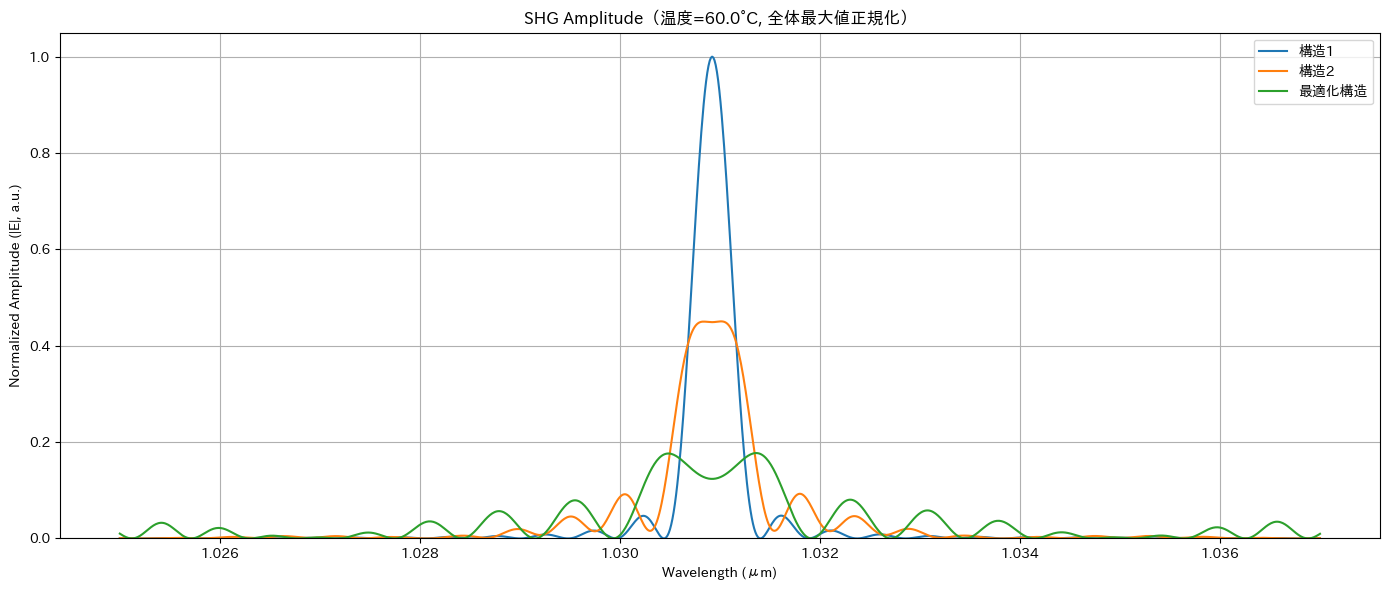

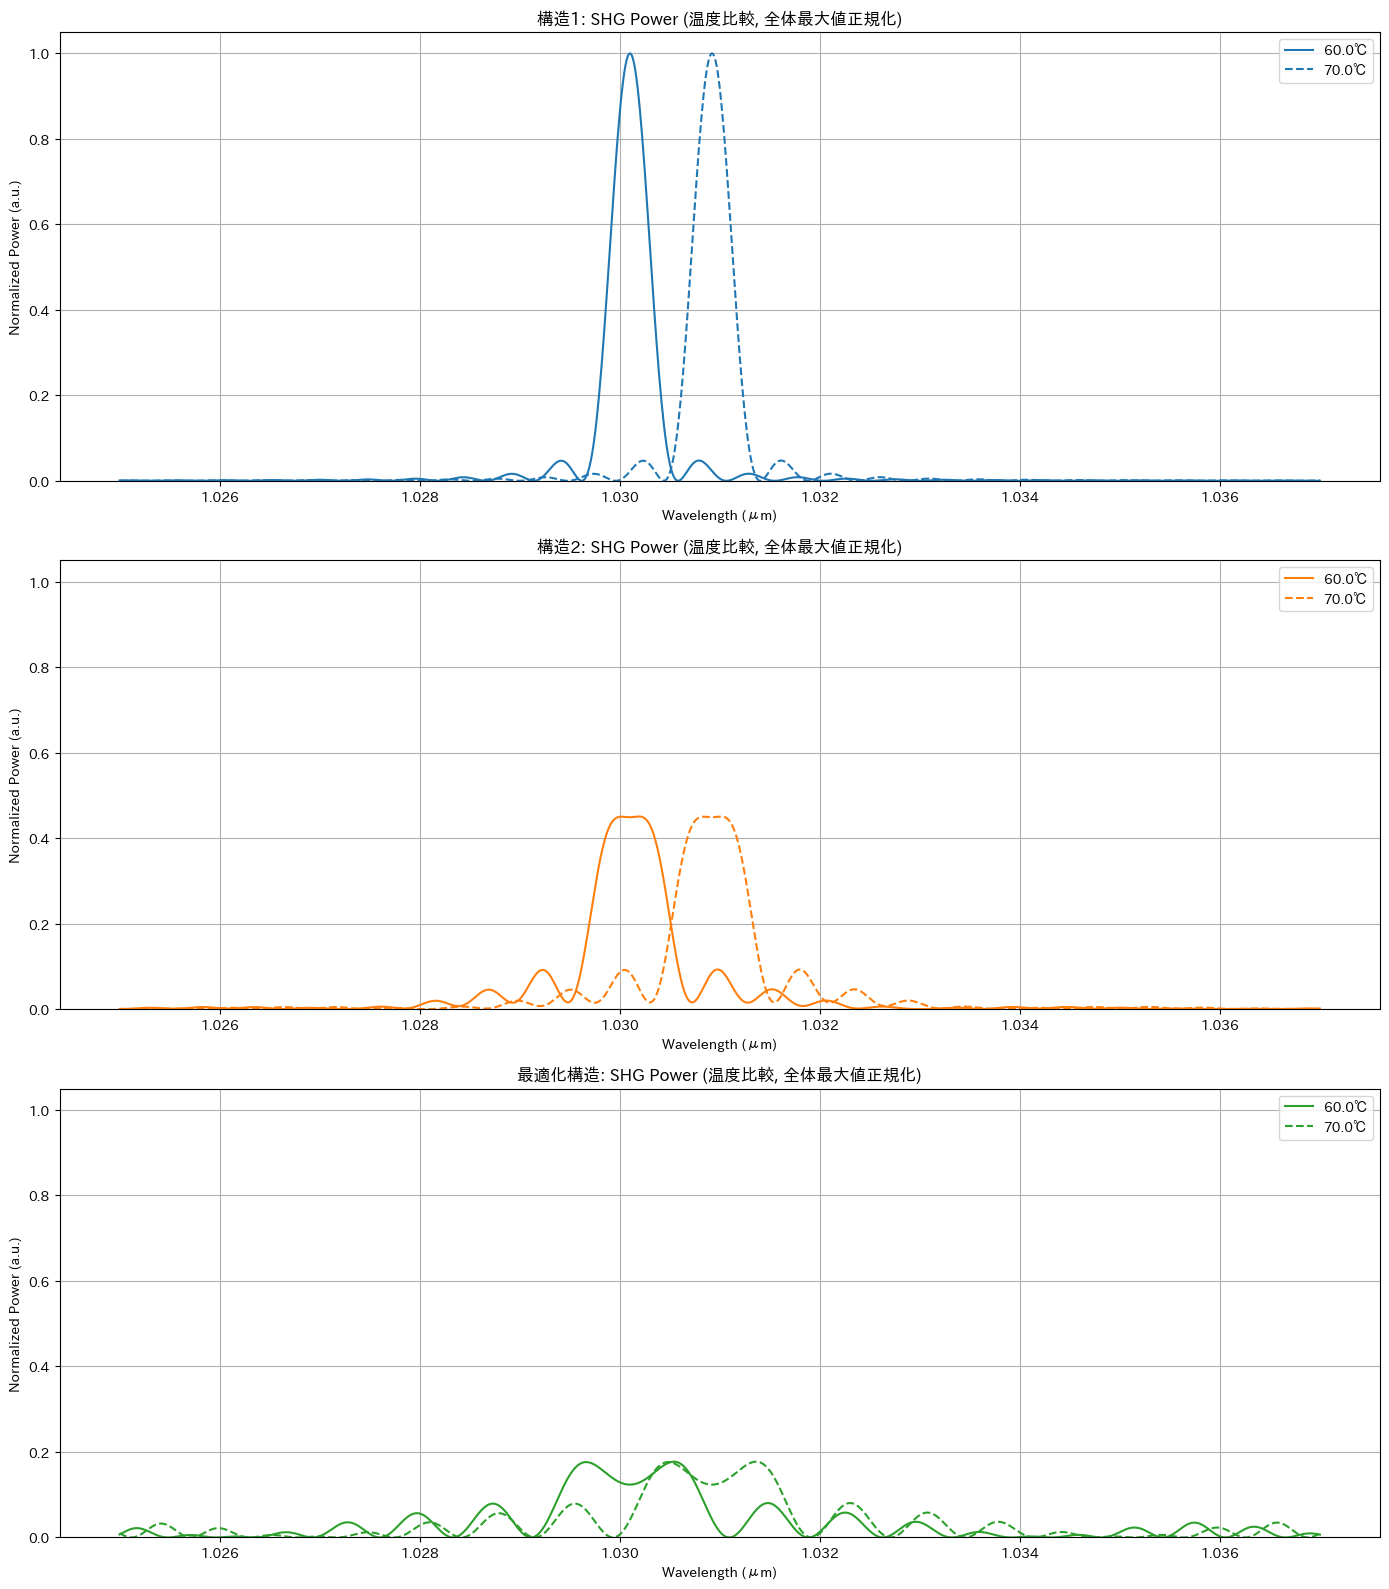

In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# 定数の定義
NUM_DOMAINS = int(DEVICE_LENGTH / DOMAIN_WIDTH)  # 1388
POINTS_PER_DOMAIN = 36  # 1ドメインあたりの信号点数 (50000 / 1388 の整数部)
TOTAL_POINTS = NUM_DOMAINS * POINTS_PER_DOMAIN  # 49968

# 最適化された信号をロード
optimized_signal = jnp.load("optimized_const_signal_5.npy")

# 信号を(1388, 36)の形状に整形
signal_reshaped = jnp.reshape(
    optimized_signal[:TOTAL_POINTS], (NUM_DOMAINS, POINTS_PER_DOMAIN))

# 各ドメインの符号を決定 (最初の点の符号を代表とする)
domain_signs = signal_reshaped[:, 0]

# 最適化構造を組み立てる
# 1列目: ドメイン幅 (すべて一定)
optimized_widths = jnp.full((NUM_DOMAINS,), DOMAIN_WIDTH)
# 2列目: 符号付きKappa
optimized_kappas = domain_signs * KAPPA
# 結合して (1388, 2) の配列にする
optimized_structure_single = jnp.stack(
    [optimized_widths, optimized_kappas], axis=1)

# --- 解析とプロット --- #

# 既存の構造と新しい最適化構造を結合
# (2, 1388, 2) と (1388, 2) -> (3, 1388, 2) にする
optimized_structure_reshaped = jnp.expand_dims(
    optimized_structure_single, axis=0)  # (1, 1388, 2) に変換
combined_structure = jnp.concatenate(
    [structure, optimized_structure_reshaped], axis=0)

# 解析実行
result_combined = mgoslt.analyze(
    shg.Params(
        grating_dim=combined_structure,
        T_dim=TEMP,
        wavelength_dim=WAVELENGTH_RANGE,
        fund_power_dim=1
    )
)


# power_combined: intensity (|E|^2)
power_combined = (jnp.abs(result_combined)**2).squeeze()

# --- 全体最大値で正規化したプロット（軸を揃える） --- #
# Amplitude, Power それぞれ全構造・全温度で最大値を取得
# colors_structuresとlabels_structuresが未定義の場合はここで定義
colors_structures = ['tab:blue', 'tab:orange', 'tab:green']
labels_structures = ['構造1', '構造2', '最適化構造']

# linestylesも未定義の場合はここで定義
linestyles = ['-', '--']

global_max_amp = jnp.max(power_combined)
fig_amp, ax_amp = plt.subplots(figsize=(14, 6))
for i in range(3):  # 構造ごと
    ax_amp.plot(
        WAVELENGTH_RANGE,
        power_combined[i, 1] / global_max_amp,
        label=labels_structures[i],
        color=colors_structures[i]
    )
ax_amp.set_xlabel("Wavelength (μm)")
ax_amp.set_ylabel("Normalized Amplitude (|E|, a.u.)")
ax_amp.set_title("SHG Amplitude（温度=%.1f°C, 全体最大値正規化）" % TEMP[0])
ax_amp.grid(True)
ax_amp.legend()
ax_amp.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Power: 各構造ごとに温度比較
global_max_pow = jnp.max(power_combined)
fig2, axs2 = plt.subplots(3, 1, figsize=(14, 16))
for i in range(3):  # 構造ごと
    for t in range(2):
        axs2[i].plot(
            WAVELENGTH_RANGE,
            power_combined[i, t] / global_max_pow,
            label=f"{TEMP[t]:.1f}℃",
            color=colors_structures[i],
            linestyle=linestyles[t]
        )
    axs2[i].set_xlabel("Wavelength (μm)")
    axs2[i].set_ylabel("Normalized Power (a.u.)")
    axs2[i].set_title(f"{labels_structures[i]}: SHG Power (温度比較, 全体最大値正規化)")
    axs2[i].grid(True)
    axs2[i].legend()
    axs2[i].set_ylim(0, 1.05)
plt.tight_layout()
plt.show()